

# Predicción de Series Temporales utilizando FbProphet

La predicción de series temporales es de los casos más habituales y aplicables dentro del Machine Learning. Por ejemplo, models de 'forecasting' se pueden encontrar en para la predicción de precios, demanda, temperatura,  tiempo de respuesta, ventas, ritmo cardiaco, producción, etc. 

El gran reto se encuentra en que, a diferencia de algunos otros casos de Machine Learning, la predicción a futuro depende en gran medida, de los datos históricos de la serie. Es decir, por ejemplo si queremos predecir la temperatura media por hora, el dato más relevante que podemos utilizar es la misma serie de temperaturas por hora. A este tipo de modelos se los llama **Auto-regresivos.** 

En la práctica, los modelos auto-regresivos pueden desarrollarse sin ninguna otra variable auxiliar (covariantes), sin embargo, es común añadir regresores externos para complementar el poder predictivo del modelo. 

## Caso de uso: Predicción de la demanda de Bicicletas en una plataforma de BikeSharing en Washington DC. 

Reto: Predecir la demanda del siguiente mes!



# Importamos paquetes y definimos helpers

In [1]:
# Instalar paquetes. - Crea un nuevo environment 
#pip install pystan==2.19.1.1
#pip install fbprophet 

# Para Windows, instala FBProphet siguiendo estos pasos. 
# https://stackoverflow.com/questions/53178281/installing-fbprophet-python-on-windows-10


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import mean_squared_error , r2_score 
import seaborn as sns
from fbprophet import Prophet
import holidays

# Set up
REGRESSOR_PRIOR_SCALE = 0.25 # Config Para Prophet. Lo veran luego


def get_median_filtered(signal, threshold=3):
    
    """
    Función que nos permite sacar outliers utilizando el método de la mediana
    filtrada. Es bastante robusto a ruido, por lo que es ideal para series 
    temporales. 
     
    Directamente reemplaza outliers con la mediana!
    Info sobre el método en 
    https://en.wikipedia.org/wiki/Median_filter 
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana    
    :return:   array igual a serie con los outliers reemplazados. 
    
    """
    
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

def plot_outliers_signal(signal, threshold = 3, return_mask = True):
    
    """
    Funcion que plotea los resultados de la funcion
    get_median_filtered
    
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana   
    :param return_mask: Si es True, devuelve los índices donde hubo reemplazo 
    :return:  in plot
    
    """
    
    
    kw = dict(marker='o', linestyle='none', color='r', alpha=0.35)

    mds = get_median_filtered(signal, threshold=threshold)
    outlier_idx = np.where(mds != signal)[0]
    plt.figure(figsize=(10,8))

    plt.plot(signal, color = "darkblue")
    plt.plot(outlier_idx,signal[outlier_idx],**kw, 
            label = "Outliers")
    plt.title("Detección de Outliers con cutoff {}".format(threshold))
    plt.legend()
    plt.show()
    if return_mask: 
      return outlier_idx


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def evaluate(true, pred):
    print('Mean squared error: %.2f'% mean_squared_error(true, pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'% r2_score(true, pred))
    print('MAPE: %.2f'%  mean_absolute_percentage_error(true, pred))

## Cargamos los Datos y exploración inicial 

In [3]:
#gdrive location:
url = 'https://raw.githubusercontent.com/patofw/sanofi_use_cases/main/Data/forecasting_exercise.csv'
df = pd.read_csv(url,parse_dates = ["dteday"]) 

In [4]:
df.head(2)

instant     dteday  hr                                       weathersit  \
0        1 2011-01-01   0  Clear, Few clouds, Partly cloudy, Partly cloudy   
1        2 2011-01-01   1  Clear, Few clouds, Partly cloudy, Partly cloudy   

   temp   atemp   hum  windspeed  casual  registered  cnt  
0  0.24  0.2879  0.81        0.0       3          13   16  
1  0.22  0.2727  0.80        0.0       8          32   40

In [5]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   hr          17379 non-null  int64         
 3   weathersit  17279 non-null  object        
 4   temp        17280 non-null  float64       
 5   atemp       17279 non-null  float64       
 6   hum         17279 non-null  float64       
 7   windspeed   17279 non-null  float64       
 8   casual      17379 non-null  int64         
 9   registered  17379 non-null  int64         
 10  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 1.5+ MB
None


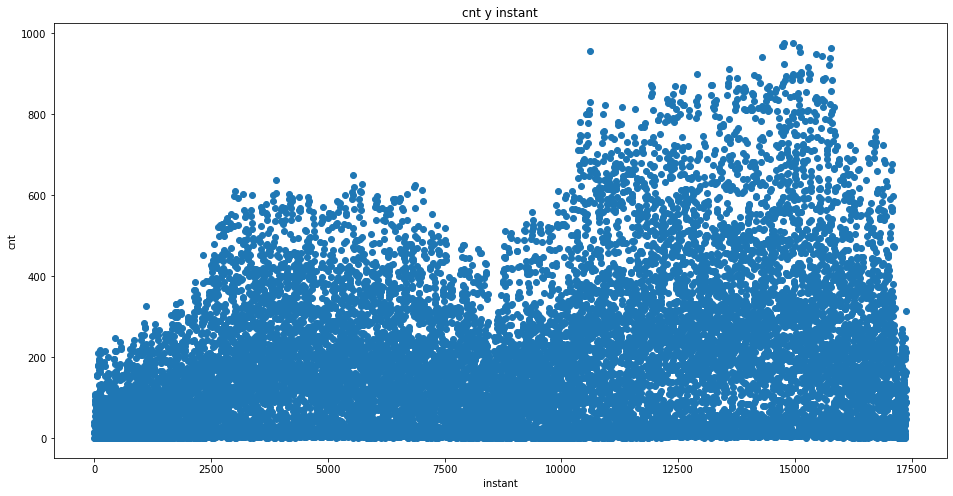

In [6]:
x = 'instant'
y = 'cnt'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

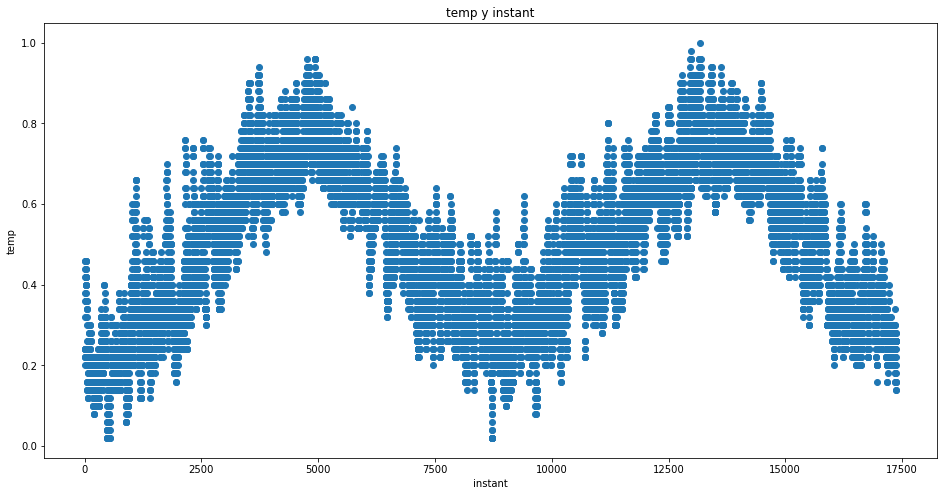

In [7]:
x = 'instant'
y = 'temp'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

<AxesSubplot:>

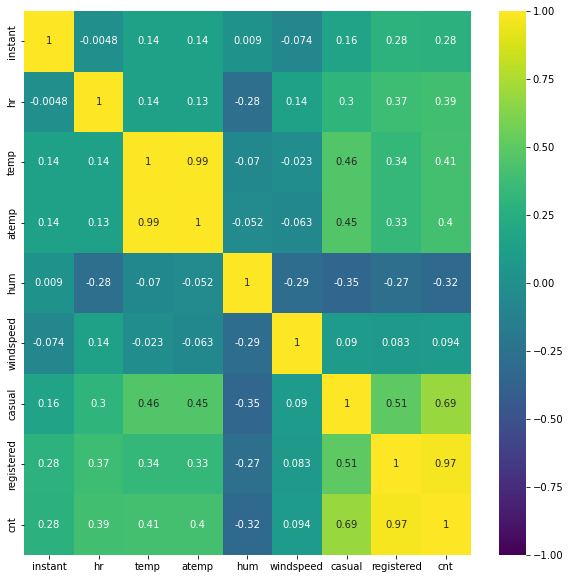

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap="viridis", vmin = -1, vmax = 1)

# Formato Datos 

Los datos están por hora, lo que dificulta en gran medida el análisis ya que se agrega muchísimo ruido de horas poco útiles. Para este caso de uso, trabajaremos con predicción de la demanda diaria. 

In [9]:
df_byday = df.groupby('dteday')['cnt'].sum().reset_index() # Sum of cnt by day 

In [10]:
df_byday.head()

dteday   cnt
0 2011-01-01   985
1 2011-01-02   801
2 2011-01-03  1349
3 2011-01-04  1562
4 2011-01-05  1600

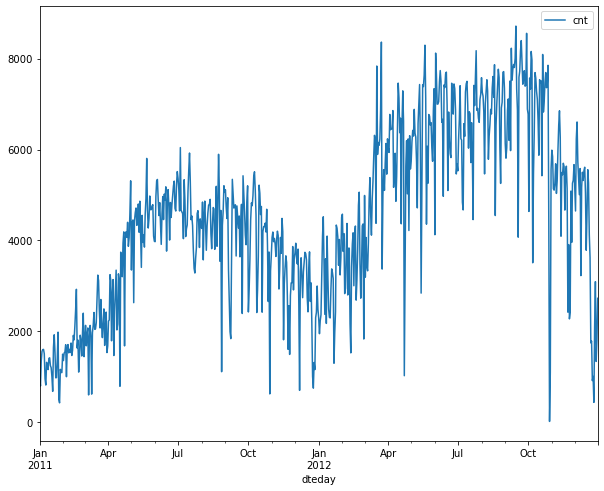

In [11]:
df_byday.plot(x='dteday',y='cnt', figsize=(10,8))
plt.show()

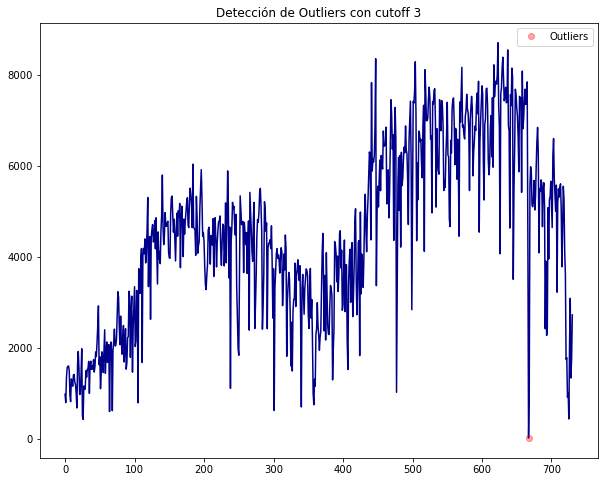

In [12]:
# Outliers
indices = plot_outliers_signal(df_byday.cnt.values, threshold = 3)
plt.show()

In [13]:
df_byday.iloc[indices]

dteday  cnt
667 2012-10-29   22

Agregamos todas las variables que nos eran útiles. Sin embargo, no todas las podemos tratar de la misma forma

# Feature Engineering ( Creamos variables a raíz de nuestros datos)

In [14]:
# ha llovido ??
rain_flag =[
    'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
    'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'
]
df['rain'] = [1 if x in rain_flag else 0 for x in df.weathersit.values]


In [15]:

# Con las fechas y dt. podemos extraer variables relevantes! Por ejemplo 
df_byday["dayofweek"] = df_byday.dteday.dt.dayofweek #to know working day or not if monday(1) -friday (5) yes + if holiday 
df_byday["dayofyear"]= df_byday.dteday.dt.dayofyear
# La temporada influye muchísimo, si hace frío no se sale a montar bicicleta
conditions = [
    (df_byday['dayofyear'] >= 61) & (df_byday['dayofyear'] <= 150),
    (df_byday['dayofyear'] >= 151) & (df_byday['dayofyear'] <= 240),
    (df_byday['dayofyear'] >= 241) & (df_byday['dayofyear'] <= 330),
    (df_byday['dayofyear'] >= 331) |  (df_byday['dayofyear'] <= 60)
    ]
#create a list of the values we want to assign for each condition
values = [1, 2, 3, 4]
#create a new column and use np.select to assign values to it using our lists as arguments
df_byday['season'] = np.select(conditions, values)
# 
us_holidays =  holidays.US()
  
conditions2 = [
    (df_byday['dayofweek'].isin([1,2,3,4,5])) & (~df_byday['dteday'].isin(us_holidays)),  #workdays
    (df_byday['dayofweek'].isin([6,0]))
    ]
values2 = [1,0]
#create a new column and use np.select to assign values to it using our lists as arguments
df_byday['is_workday'] = np.select(conditions2, values2)

# Re append the temperature and rain flag 
df_byday['temp'] = df.groupby('dteday')['temp'].mean().values # mean temp
df_byday['rain'] = df.groupby('dteday')['rain'].mean().values # mean of rain**
# ** Si llueve todo el día, la media estará cerca de 1, si llueve poco, cerca a 0



In [16]:
df_byday.head()

dteday   cnt  dayofweek  dayofyear  season  is_workday      temp  \
0 2011-01-01   985          5          1       4           1  0.344167   
1 2011-01-02   801          6          2       4           0  0.363478   
2 2011-01-03  1349          0          3       4           0  0.197143   
3 2011-01-04  1562          1          4       4           1  0.200000   
4 2011-01-05  1600          2          5       4           1  0.226957   

       rain  
0  0.083333  
1  0.217391  
2  0.000000  
3  0.000000  
4  0.000000

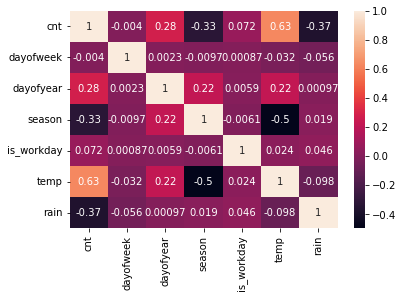

In [17]:
# Veamos correlación entre variables 
sns.heatmap(df_byday.dropna().corr(), annot=True);

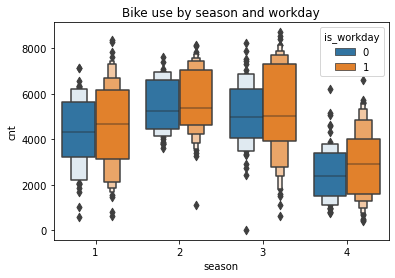

In [18]:
sns.boxenplot(data = df_byday, x ='season', hue='is_workday',y='cnt' )
plt.title('Bike use by season and workday');

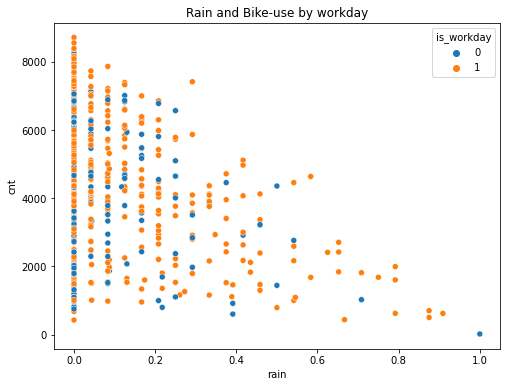

In [19]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data = df_byday, x ='rain', y='cnt', hue='is_workday')
plt.title('Rain and Bike-use by workday');

In [20]:
abs(df_byday.corr()['cnt']).sort_values(ascending=False)

cnt           1.000000
temp          0.627631
rain          0.369099
season        0.330136
dayofyear     0.277433
is_workday    0.072436
dayofweek     0.003985
Name: cnt, dtype: float64

# Modelo de Machine Learning

In [21]:
# separación 

ext_reg = ["temp",'rain','season','dayofyear','is_workday']
target = 'cnt' # our target var
train_cut = "2012-12-01"
# Separamos test de train
train = df_byday[df_byday.dteday < train_cut]
test = df_byday.copy()
# Formato para  Prophet 
train_proph = train[['dteday',target] + ext_reg]
#test dataset
X_test = test[train_proph.columns]
y_test = test[target]
X_test[target] = np.nan # quitamos valores del X_test en la target var 
 
# Llenamos NA ->  Usamos la temperatura del día anterior para llenar nulos 

train_proph['temp'] = train_proph.temp.fillna(method='ffill') # forward fill
X_test['temp'] = X_test.temp.fillna(method='ffill') # forward fill

# Renombramos la variable cnt cnt name a y como pide Prophet 
train_proph.rename(columns={target:'y', 'dteday':'ds'}, inplace=True)
X_test.rename(columns={target:'y', 'dteday':'ds'}, inplace=True)

/var/folders/g9/cjl__p5n18j7_y_2lx39ww4m0000gn/T/ipykernel_52443/24745043.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[target] = np.nan # quitamos valores del X_test en la target var
/var/folders/g9/cjl__p5n18j7_y_2lx39ww4m0000gn/T/ipykernel_52443/24745043.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_proph['temp'] = train_proph.temp.fillna(method='ffill') # forward fill
/var/folders/g9/cjl__p5n18j7_y_2lx39ww4m0000gn/T/ipykernel_52443/24745043.py:19: SettingWithCopyWarning: 
A va

In [22]:
# Try basic Prophet model first, adding external regressors (covariates)
m = Prophet()  # Prophet por defect
for reg in ext_reg: # adding regressors to the Prophet model 
  m.add_regressor(
    reg, mode='additive'
  )
# Train the model.
m.fit(train_proph)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1337.61   0.000601691       100.215           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       1337.86   2.04177e-08       81.0008      0.3606           1      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


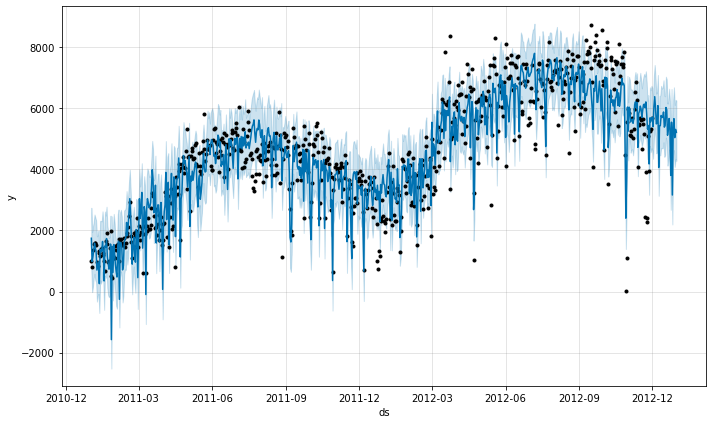

In [23]:
# predict
forecast = m.predict(X_test)
fig = m.plot(forecast);

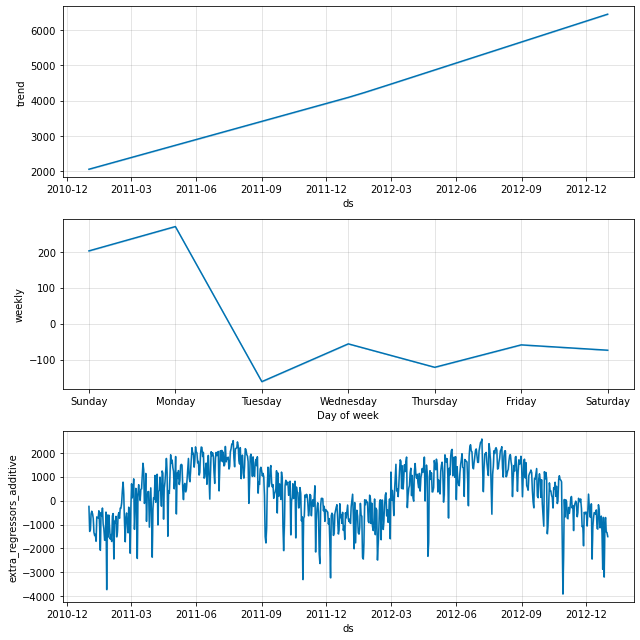

In [24]:
fig = m.plot_components(forecast);

In [25]:
predicted = forecast[forecast.ds >= train_cut].yhat
real = y_test[-len(predicted):]

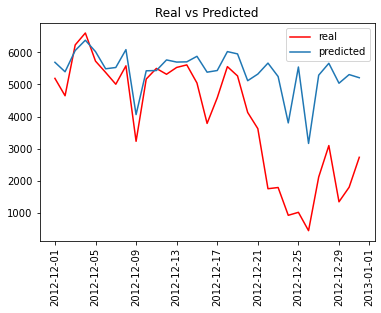

In [26]:
x = X_test.ds[-len(predicted):]
plt.plot(x, real, c='red', label='real')
plt.plot(x, predicted, label='predicted')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Real vs Predicted');

In [27]:
# imprimios evaluación
evaluate(real, predicted)

Mean squared error: 3983324.95
Coefficient of determination: -0.27
MAPE: 0.92


## Optimización de Hyperparámetros

Prophet da resultados decentes en su versión "out-of-the-box", pero se puede llegar mucho más lejos si se optimiza en hyper-parámetros. Prophet nos permite optimizar en varios parámetros de forma eficiente, obteniendo los mejores resultados posibles para nuestro modelo. Mientras más grande el search-space, más tiempo demorará la optimización.

Más información en el siguiente [link](https://facebook.github.io/prophet/docs/diagnostics.html)

In [28]:
import itertools 
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation

cv_forecast_horizon = '21 d'

TRAIN_GRID = {  
  'changepoint_prior_scale': [0.3, 0.5 ,0.7],
  'seasonality_prior_scale': [7, 10],
  'yearly_seasonality': [7, 10],
  'seasonality_mode': ['additive', 'multiplicative'],
  'changepoint_range': [0.5, 0.7, 0.9],
}

all_params = [
  dict(zip(
    TRAIN_GRID.keys(),
    v)) for v in itertools.product(
    *TRAIN_GRID.values())]
tuning_results = pd.DataFrame()
# Use cross validation to evaluate all parameters # it can be parallelized.
i = 1
n_params = len(all_params)
for params in all_params:
  print("Fitting {}/{}".format(i,n_params))
  print(params)
  # Fit model with given params
  m = Prophet(**params)  
  for reg in ext_reg: # adding regressors to the Prophet model 
      m.add_regressor(reg,
              prior_scale=REGRESSOR_PRIOR_SCALE, 
              mode='additive')
  # fit the model 
  m.fit(train_proph)
  # Crossvalidate time series 
  df_cv = cross_validation(m,
                          initial='100 days',
                          period='30 d',
                          horizon = cv_forecast_horizon, 
                          parallel='processes') 
  print("Collecting metrics")
  # collecting metrics
  df_p = performance_metrics(df_cv,rolling_window=0)
  params_results = pd.DataFrame(df_p)
  for key in params.keys():
      params_results[key] = params.get(key)
  print("Collecting results")
  tuning_results = tuning_results.append(params_results)
  i = i+1
  _params = tuning_results.sort_values(['horizon','mape'])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 1/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}
Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1447.93     0.0075782       52.4766           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1450.89    0.00128107       44.9418      0.3174      0.3174      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1452.13    0.00145684       58.3751      0.4721      0.4721      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1452.97     0.0121112       72.2832      0.7089      0.7089      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals 

INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b957f730>


Initial log joint probability = -3.35865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       216.354    4.6753e-05       16.6532      0.3647      0.3647      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       216.356   8.58568e-07       16.0404   5.047e-08       0.001      254  LS failed, Hessian reset 
     181       216.356   2.58748e-08       16.6002      0.2878      0.7367      270   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.52972
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       307.926     0.0216649       68.6414           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       309.039    1.7046e-05        13.554       0.288          

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 2/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a9e74f70>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1450.55    0.00771001       55.1749           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1455.01   0.000763877       32.0897           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1455.86     0.0131967        42.182           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1456.67   0.000669455       23.8537           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     418       1456.87   0.000261623       38.4579   5.455e-06       0.001      499  LS failed, Hessian reset 
     493       1457.15   0.000480268    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 3/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b95692b0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          1453     0.0381362       58.7826           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1456.57    0.00090891       25.3443           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1457.6    0.00116639       42.8719           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1458.33    0.00222053       48.1339           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1459.1   0.000852714       35.7725      0.6228      0.6228      564   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 4/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a9e6da00>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1466.17     0.0154009       83.4119           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1468.58    0.00076881       58.1002           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       1469.02   0.000148446       49.8238   3.209e-06       0.001      324  LS failed, Hessian reset 
     299       1469.26   0.000352599       30.1351      0.8417      0.8417      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1469.77   0.000140583       47.5498      0.3412      0.3412      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1470.07     0.0239108    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 5/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968ae03d90>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1466.75    0.00456616       82.6426       1.368      0.1368      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1469.34   0.000884911       24.9907           1           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          1470    0.00109503       28.7139      0.4736           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393       1470.49   5.43754e-05        16.656   2.679e-06       0.001      463  LS failed, Hessian reset 
     399       1470.52    0.00199374       53.3161           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1470.87    0.00190913    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 6/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a96dfd90>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1466.96    0.00585514       33.3125           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1469.29    0.00331603       24.5421           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1470.19    0.00305754       38.0255           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1470.57   0.000259567       10.5737      0.3277      0.9987      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1470.78   0.000164206       13.9653      0.3615           1      594   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b957fd90>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1455.52     0.0105182        48.612           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1457.39    0.00135656       47.8229           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1459.18     0.0236376       86.4793           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1460.24   0.000161117       42.8294   4.402e-06       0.001      490  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1460.7   9.88402e-05       27.6684      0.1534      0.1534      602   
    Iter      log prob        ||dx||    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 8/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968aab43d0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1459.24     0.0225348       86.9431           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1462.01    0.00737189       95.6339           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       1462.67   0.000162476       31.1958    2.27e-06       0.001      325  LS failed, Hessian reset 
     299       1463.04    0.00045237       30.2239      0.3034      0.3034      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     373       1463.48     0.0002657       49.5434   3.898e-06       0.001      515  LS failed, Hessian reset 
     399       1463.73    0.00191282       23.9585           1           1      544   
    Iter      log pro

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 9/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b9634610>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1458.97    0.00383159       59.4075           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1463.09    0.00511143       73.7957      0.7098      0.7098      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1464.3   0.000299651       43.2657      0.2769      0.2769      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1465.18    0.00360688       28.4514           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     485       1465.53   0.000572344       35.8326   3.714e-05       0.001      606  LS failed, Hessian reset 
     499        1465.6   0.000527436    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 10/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b941fca0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1474.12    0.00816774       275.718       0.584       0.584      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1477.33     0.0111544       71.7103       0.495           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1478.08     0.0139107       79.7131           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316        1478.2   4.92626e-05       15.1832   1.598e-06       0.001      396  LS failed, Hessian reset 
     399       1478.71   7.82016e-05       25.9977      0.4555      0.4555      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1479.42   0.000612566    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 11/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a9e74a60>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1474.97    0.00224201       67.8829           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1477.49     0.0023195       78.6433        0.75        0.75      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1478.35    0.00074312       27.2336           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          1479   0.000965886       18.4992       0.838       0.838      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1479.39   0.000828321       20.1579           1           1      567   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 12/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968a05a970>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1473.6     0.0271026       106.838           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1477.21    0.00138818       16.4365           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       1477.43   0.000251695       35.6644    7.55e-06       0.001      293  LS failed, Hessian reset 
     270       1477.79   0.000163662       28.9348   6.713e-06       0.001      376  LS failed, Hessian reset 
     299       1477.97   0.000313404       20.3241           1           1      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1478.79    0.00138346       33.3442           1           1      517   
    Iter      log pro

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 13/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a9e74a60>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1448.51     0.0125907       306.283           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1451.52    0.00119403       34.0727           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1453.15    0.00248574       30.6065           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362       1453.57   8.82999e-05       27.2764   3.729e-06       0.001      458  LS failed, Hessian reset 
     399       1453.68   0.000284586       11.9364      0.6124           1      505   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     481       1453.91   0.000152569    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 14/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968ae0e820>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1450.33    0.00378082       105.605      0.5125           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1454.48   0.000886938        46.146      0.6647      0.6647      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1455.63    0.00302235       36.1114      0.5275           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1456.76   0.000658489       16.8904      0.4395           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1457.77    0.00850084       19.3187           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a96e6cd0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1452.93     0.0178892       107.107           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1456.78   0.000165541       23.2895      0.7745      0.7745      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286        1457.6   0.000169327       32.6145   5.942e-06       0.001      359  LS failed, Hessian reset 
     299        1457.7    0.00075317       38.0491      0.7548      0.7548      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     383       1458.15   0.000259912       47.0854   3.238e-06       0.001      503  LS failed, Hessian reset 
     399       1458.29    0.00166093       15.8923           1           1      521   
    Iter      log pro

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 16/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a96df0d0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1466.87    0.00578751       67.5383           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1468.77     0.0113859       47.9601           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1469.59    0.00874701       61.2638           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1469.96   8.65766e-05       17.5244      0.3591      0.3591      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1470.15   0.000457724       14.6789           1           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968aab4520>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1466.09    0.00803117       87.7932           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1469.29    0.00208947        39.682           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1470.4   0.000439847       28.6919       0.819       0.819      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       1470.64   0.000112644       29.4264   4.119e-06       0.001      423  LS failed, Hessian reset 
     399       1470.74    0.00215642       21.6846           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     435        1470.9   5.25141e-05    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 18/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968a1417c0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1466.72    0.00354025       45.0286           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1469.35     0.0011639       53.3742       0.371       0.371      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1470.13   0.000140246       18.5726      0.5624      0.5624      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       1470.21   8.82799e-05        22.222   3.399e-06       0.001      400  LS failed, Hessian reset 
     399        1470.5   0.000932307       25.5542           1           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1470.75    0.00014109    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 19/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a96e2130>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1455.67   0.000648173       48.1568           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1457.96    0.00455656       83.3611           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1460.08     0.0145252       71.1609      0.4631           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1460.65   0.000106506       11.1568      0.4759      0.4759      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       1460.71   0.000181361       48.2352   5.448e-06       0.001      528  LS failed, Hessian reset 
     499       1460.95    0.00357078    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b963f220>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1459.28     0.0161327       79.1027           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1461.9    0.00293281       65.4048           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1462.92    0.00264735       21.3101           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1463.47    0.00397394        33.665           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1464.35    0.00415683        40.561           1           1      566   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 21/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b96224c0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1459.36      0.118966       310.786           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1463.46    0.00399525       58.7665      0.8106      0.8106      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1464.44   0.000272118       36.5477      0.1419           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1464.97    0.00025371       19.4271      0.8758      0.8758      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     437       1465.07   0.000103638        20.031   5.923e-06       0.001      529  LS failed, Hessian reset 
     499       1465.22     0.0127856    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968a17a820>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1474.92    0.00398637       112.738           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1477.28    0.00831605       43.3402           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1478.45   0.000388939        43.777      0.3862      0.3862      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1479.24   0.000165041       22.2682      0.8387      0.8387      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1479.47   0.000186802       22.9027      0.3634      0.3634      566   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 23/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a9e6d8b0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1475.41    0.00135753        99.331           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1477.61    0.00989557       70.7794           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1478.35    0.00117871       28.5452      0.5156      0.5156      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1479.18    0.00128651       19.5893      0.8367      0.8367      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1479.35    0.00169794        26.144           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 24/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b96226a0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1474.52    0.00258575       107.021      0.2293      0.2293      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1477.14     0.0220257       32.2744           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          1478   0.000297155       19.3817      0.5324           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1478.91   0.000906042        26.667           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     447       1479.02   0.000158098       26.6626   1.306e-05       0.001      548  LS failed, Hessian reset 
     499       1479.09    0.00176435    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 25/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b957fd90>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1450.48     0.0237801       62.6201           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1458.57     0.0117586       51.3201           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1459.62    0.00365307       21.8616      0.8505      0.8505      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1460.6    0.00228454       24.9302           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     445       1460.79   4.37314e-05       11.3762   2.011e-06       0.001      534  LS failed, Hessian reset 
     499       1460.96    0.00369483    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 26/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b96239d0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1457.06     0.0363971       129.053           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1462.03    0.00780567        61.409           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1463.06    0.00155888       28.7563           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1463.8    0.00823409       54.7571      0.2697           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1464.33   0.000412836       14.6952           1           1      549   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 27/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a96dfd00>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1457.85     0.0337863        335.64      0.3183      0.3183      105   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1462.44   0.000902983       16.6505      0.8829      0.8829      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1464.13    0.00206582       32.9159           1           1      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1464.75    0.00439071       24.2127           1           1      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1465.39      0.003057       51.9716           1           1      537   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 28/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a96f3370>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1467.09    0.00806239       212.366      0.4124           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1473.28    0.00297079        69.365       2.053      0.2053      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1474.34   0.000733788       29.3928      0.3738      0.3738      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1474.82    0.00139226       18.1136           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     493        1475.2   6.92411e-05       24.7534   2.503e-06       0.001      610  LS failed, Hessian reset 
     499       1475.23    0.00110195    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 29/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968ae0fb80>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1471.46     0.0176694       281.905           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1474.54    0.00303435         42.73           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1475.63    0.00765228       47.3258      0.5772      0.5772      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1476.22      0.010029       27.5081           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1476.66    0.00504813        15.233           1           1      548   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a1310130>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1466.26     0.0153424       249.247      0.3253           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1474.17   0.000592488       16.5906           1           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1475.16    0.00374897       34.7683           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1475.59    0.00262912       34.7478      0.8304      0.8304      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     494       1476.22   0.000752363       38.8433   4.115e-05       0.001      575  LS failed, Hessian reset 
     499       1476.23     0.0007859    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 31/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968ad7be80>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1458.39     0.0134406       217.002      0.2636           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1465.01    0.00187067       53.3857      0.8397      0.8397      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     290       1466.03    9.9939e-05       29.1037   2.021e-06       0.001      365  LS failed, Hessian reset 
     299       1466.13   0.000510514       19.7291           1           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1467.17    0.00978109       23.9625           1           1      486   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1467.51    0.00782243    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b94a24c0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1461.19    0.00764158        74.749           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1468.41    0.00142199       16.3153      0.8813      0.8813      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1469.05    0.00154336        36.669      0.3767           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1469.69    0.00250479       39.8755           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1470.31   0.000230773       42.6134      0.6349      0.6349      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b95692b0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1459.75    0.00590491       76.5412           1           1      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1469.21     0.0133737       98.6858           1           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1470.43    0.00106281       15.4937           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1470.78    0.00140517       20.2778           1           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1471.05    0.00266711       21.0579           1           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 34/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a96e6be0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1478.26     0.0314071       144.929      0.5217      0.5217      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1481.58   0.000567839       20.4952           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1482.57    0.00115702         23.22           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1483.23    0.00277384       29.0655           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1484.02   0.000448642       40.3586      0.5231      0.5231      559   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 35/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b941fca0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1478.99    0.00249412       71.0334           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1482.25   0.000369782       11.9418      0.7348      0.7348      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1483.23     0.0123505       42.9112      0.7796      0.7796      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       1483.29    7.0257e-05       21.2327   2.056e-06       0.001      379  LS failed, Hessian reset 
     399       1483.88    0.00155471       17.0042           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1484.19     0.0020838    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 36/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968ab573d0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1478.69     0.0151511       85.8134           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1481.6    0.00270207       27.9113           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1482.67    0.00203349       35.7034           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1483.19   0.000488917       11.8699           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1483.61    0.00374223       21.0585           1           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 37/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a96f33a0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1449.66    0.00593264       30.9517           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1458.34     0.0406386       206.673      0.8244      0.8244      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1460.38    0.00217882       24.2842           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1461.38   0.000564658       44.1023           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     433       1461.49   9.74092e-05       29.4809   4.414e-06       0.001      511  LS failed, Hessian reset 
     487       1461.69   9.17805e-05    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a96f3280>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1460.69    0.00439327       53.3326           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1461.93    0.00745017       56.4915           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1463.2   0.000724041       12.3766       0.818       0.818      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1463.81    0.00302192       38.1009           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1464.41    0.00166648       31.3705      0.6272      0.6272      548   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 39/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b963a7f0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1459.51    0.00780522       67.9969      0.6301      0.6301      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1462.67    0.00105779        36.363           1           1      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1464.01    0.00471012       45.7262      0.8622      0.8622      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1464.62   0.000488958       20.5325      0.6648      0.6648      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1465.33    0.00352503       74.4026           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 40/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b94d51f0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1469.91     0.0319377       118.865           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1473.14   0.000830517       19.8809           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1474.46   0.000643275       27.6523      0.9926      0.9926      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1474.85    0.00573349       20.3792           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1475.3    0.00130474        33.175      0.9897      0.9897      563   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 41/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b9640340>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1471.51      0.012725       258.394           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1474.5     0.0248354       102.829           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1475.59   0.000211943       21.1405      0.4811      0.4811      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1476.22   0.000552416       7.15829       0.702       0.702      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1476.62     0.0013652       59.3348           1           1      577   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 42/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a968b130>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1470.85      0.022416       305.144      0.3577           1      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1474.12    0.00254436       16.7487           1           1      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1475.18     0.0129402       70.6592           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1475.89   0.000478402       23.8331           1           1      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1476.19   0.000564713        12.194           1           1      548   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 43/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b95692b0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1457.86    0.00392496       157.679           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1465.08     0.0157515       138.665           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1466.78    0.00153641       45.6272           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1467.54    0.00267782       45.5562           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     488       1467.94    0.00063698       33.3069    2.27e-05       0.001      571  LS failed, Hessian reset 
     499       1467.97   0.000531941    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 44/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b93d0af0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1461.37    0.00281683       91.1471           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1467.31    0.00318919       19.0597           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1469.23     0.0439385       119.137      0.5204           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1470.1     0.0014265       23.1222           1           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1470.55   0.000855832       27.7583           1           1      557   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 45/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968a151dc0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1463.04     0.0610976       144.478           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1467.85    0.00072995       15.1465           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1469.8   0.000586861       27.0206           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1470.46   0.000407497       19.2481      0.9018      0.9018      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1471.12     0.0486927       26.2916      0.8752      0.8752      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 46/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968b54c6a0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1477.79     0.0153126       521.588      0.1119           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1482.01     0.0020757       21.5179           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1482.66    0.00481752       59.1929           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1483.29     0.0034504       25.9551           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1483.78    0.00116513        28.423      0.4764      0.4764      563   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 47/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b93fdc40>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1477.67    0.00714393       108.425           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1482.48    0.00146143       51.6466           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1483.09    0.00456784       31.9211      0.2405           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1483.98   0.000703036       17.6706           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       1484.19   9.08821e-05       28.6235   2.351e-06       0.001      516  LS failed, Hessian reset 
     499       1484.37   0.000290846    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 48/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b93d0a90>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1478.71    0.00372518       50.8505           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1482.09    0.00118879       45.7462      0.3723           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1482.67     0.0153069        52.643           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1483.31   0.000464614       23.0549      0.6333      0.6333      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1483.57   0.000918877       18.6175      0.3971           1      564   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 49/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968b5083a0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1452.1     0.0536038       452.637      0.5254           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1462.46    0.00887829       19.3417           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1463.19     0.0308879       87.7844           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1465.46     0.0300948       117.946           1           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1465.95   0.000695357       23.2282           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 50/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b963a7f0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1459.73     0.0018197         174.7      0.7332      0.7332      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1466.06     0.0647887       40.6566           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1467.24    0.00166958       39.8671           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1467.82   0.000558942       9.60539           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1468.63   0.000766463       25.4221           1           1      557   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 51/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b93fdc40>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1455.42     0.0118501       77.9379           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1465.8     0.0034794       50.0348      0.8564      0.8564      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1467.05    0.00336169       54.8479           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1467.82    0.00300259       17.8382           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1468.73   0.000473081       15.5002           1           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 52/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}
Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1471.05     0.0190344       160.199           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1476.01   0.000465772       22.8896           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1477.3     0.0102955       25.7538           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1478.37   0.000787649       13.9673           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b941fca0>


Initial log joint probability = -3.35865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       218.529    0.00729902       14.9329           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       218.652    5.2086e-05       5.73987   7.307e-06       0.001      238  LS failed, Hessian reset 
     197       218.653   9.67971e-08       5.78759      0.6954      0.6954      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.23594
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       378.506    0.00623828       22.8691       2.121      0.2121      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        379.36     0.0121953       19.3142           1          

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 53/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968a1140a0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1472.42     0.0293811       313.872           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1477.57    0.00240094       26.6381           1           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1478.78   0.000885032       21.6911           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1479.43   8.01775e-05       15.2643      0.4039      0.4039      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1479.8     0.0136802       22.7184       0.686           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 54/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968aab43d0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1473.02   0.000534397       100.008      0.3246      0.3246      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1477.11    0.00502113       80.5366       0.324           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1478.18   0.000555679       14.7025           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1478.53    0.00082695       17.9799           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1478.96    0.00263104        21.276           1           1      546   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 55/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968aab4d00>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1460.55     0.0300875       211.361           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1467.24    0.00322442       84.5648           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1470.88    0.00688056       58.1615           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1471.89      0.025511       97.0448           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1472.48   0.000361595       20.5924      0.7935      0.7935      564   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 56/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a9e4e340>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1463.2      0.012629        125.42           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1472.08   0.000433804       16.9624      0.4153      0.9563      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1473.34    0.00201546       20.9368      0.6227      0.6227      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1473.55    0.00294586       17.3457           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1474.64   0.000814993       34.0131     0.07732      0.2399      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 57/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968b54cf70>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1465.05     0.0977983       94.1685           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1472.57    0.00179894       58.7703      0.2292           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1473.67   0.000264387       23.5618      0.3914      0.3914      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1474.25   0.000199088       13.0366       0.785       0.785      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     446       1474.57    0.00011125       17.5101   4.078e-06       0.001      544  LS failed, Hessian reset 
     499       1474.91     0.0209778    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 58/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a96e6b20>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1480.69     0.0331868       152.354           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1484.67   0.000528489       16.5449           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1485.36    0.00106962       41.7635      0.3594           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1486.42    0.00915308        37.652           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1487.05   0.000494737       14.1726           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 59/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a96f3280>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1481.37    0.00582263       75.9764           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1484.65   0.000770639       18.9842      0.8791      0.8791      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1485.73    0.00633567       69.7215           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1486.17    0.00106807       46.8651      0.7077      0.7077      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1487.11    0.00153971       27.8979      0.2869           1      535   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 60/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968b54cd90>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          1482     0.0251007       106.464           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1484.35     0.0034623       47.2684           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1485.23    0.00103364       26.1309           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          1486    0.00412596       26.7034           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1486.41    0.00179546       32.8725      0.3753           1      562   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 61/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968ab57250>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1451.02    0.00823785       97.0253           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1462.49    0.00805015       78.5844           1           1      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1463.8    0.00547386       61.0829           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1464.72    0.00166519       15.0255           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1465.77    0.00109117       10.1252           1           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 62/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b94a24c0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1456.18    0.00377835       60.5034           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1466.29     0.0561058       71.4356           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1466.98   0.000123995       16.0954      0.3664      0.3664      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1467.71    0.00644554       14.7529           1           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1468.48    0.00343337       33.5263           1           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 63/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968ab57250>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1463.63      0.048359       96.9967           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1466.53    0.00202809       20.7281           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1467.61     0.0186326       69.9968           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1468.56     0.0104306         64.89           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1469.51   0.000365189       14.8867           1           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 64/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b94bd130>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1469.47     0.0225563       338.335           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1475.71   0.000720435       29.0625           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1477.27    0.00292976       87.7961      0.8677      0.8677      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1478.07    0.00151883       33.1453           1           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1478.98   0.000583606       37.8619      0.6835      0.6835      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 65/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f968a14cee0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1473.95    0.00427818       110.472       0.953       0.953      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1477.24    0.00698943       69.3918      0.8656      0.8656      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1478.55   0.000545633       20.8084       0.689       0.689      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1479.11   0.000536449       21.4943           1           1      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1479.63   0.000127164       11.2298           1           1      546   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 66/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a1310bb0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1473.6      0.044777       163.497           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1476.71    0.00316362       47.4921      0.4026           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1478.08    0.00094051       17.6807       0.441           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1478.69    0.00166198       25.1293           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1479.54    0.00124689       37.6423           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 67/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b9402fa0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1458.64    0.00495108       62.3645      0.9851      0.9851      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1469.25    0.00724243       46.6169           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1470.52    0.00393485       18.0468       2.075      0.2075      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1471.43     0.0121226       37.0372           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1471.76   0.000248051       11.7814      0.7351      0.7351      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 68/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a96f3280>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1461.22    0.00851308       115.723           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1472.08    0.00240509       32.4638           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1473.16   0.000683957       41.6478      0.5265      0.5265      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1473.66    0.00369962       23.3995           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1474.02    0.00281421       19.5478      0.5531      0.5531      567   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 69/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b963a7f0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1469.14     0.0117019       80.0748           1           1      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1472.47     0.0356818       77.5278           1           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1473.94    0.00976337       75.3351           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1474.43   0.000930554       13.7106           1           1      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     477       1475.01   0.000227829       38.3636   1.205e-05       0.001      565  LS failed, Hessian reset 
     499       1475.14    0.00901696    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 70/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b9640340>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1481.15     0.0184815       81.8714           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1484.5    0.00586438        54.895           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1485.44    0.00625916       25.4758           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1486.48     0.0160265       56.0848           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1487.17   0.000841853       70.9273      0.8935      0.8935      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 71/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96b9402fd0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1480.01    0.00620102       48.0896           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1484.81    0.00341282       33.9433           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1485.77    0.00408428       26.8983           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1486.37   0.000737592       11.2684           1           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1487.06    0.00014429       18.2807      0.7342      0.7342      553   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 72/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:fbprophet:Making 20 forecasts with cutoffs between 2011-04-19 00:00:00 and 2012-11-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96a1310bb0>


Initial log joint probability = -17.3222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1481.83     0.0176353       103.631           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1484.3    0.00674684       41.7455           1           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1485.12   0.000792811       20.3674      0.4917      0.4917      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1486.17    0.00111532       18.7967           1           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1486.67     0.0048478       15.9406           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [29]:
_params[_params.horizon == cv_forecast_horizon]

horizon           mse         rmse          mae      mape     mdape  \
20 21 days  3.372484e+06  1836.432466  1307.977444  0.297033  0.192458   
20 21 days  6.140100e+06  2477.922583  1433.466152  0.300132  0.164883   
20 21 days  4.095762e+06  2023.798887  1415.660323  0.327365  0.180334   
20 21 days  4.305614e+06  2074.997445  1439.424705  0.332430  0.182170   
20 21 days  4.473389e+06  2115.038793  1475.943176  0.334052  0.213542   
..     ...           ...          ...          ...       ...       ...   
20 21 days  2.071810e+07  4551.713893  3157.211647  0.788575  0.251307   
20 21 days  3.244983e+07  5696.475223  3344.961305  0.793092  0.279246   
20 21 days  5.401235e+07  7349.309193  3700.269969  0.885884  0.273882   
20 21 days  6.201398e+07  7874.895787  4151.855494  0.901117  0.425700   
20 21 days  6.954425e+07  8339.319339  4514.384542  0.971281  0.331081   

    coverage  changepoint_prior_scale  seasonality_prior_scale  \
20      0.30                      0.3                        7   
20      0.35                      0.7                       10   
20      0.35                      0.3                       10   
20      0.40                      0.3                        7   
20      0.30                      0.3                        7   
..       ...                      ...                      ...   
20      0.35                      0.7                        7   
20      0.20                      0.7                       10   
20      0.30                      0.7                       10   
20      0.10                      0.7                        7   
20      0.10                      0.7                       10   

    yearly_seasonality seasonality_mode  changepoint_range  
20                   7         additive                0.7  
20                  10         additive                0.5  
20                   7         additive                0.5  
20                   7         additive                0.5  
20                   7         additive                0.9  
..                 ...              ...                ...  
20                   7   multiplicative                0.9  
20                  10   multiplicative                0.5  
20                   7   multiplicative                0.5  
20                  10   multiplicative                0.7  
20                  10   multiplicative                0.7  

[72 rows x 12 columns]

In [30]:
# choosing best params 
best_params = _params[
    _params.horizon == cv_forecast_horizon
][list(TRAIN_GRID.keys())]
best_params = best_params.iloc[0].to_dict()

In [31]:
best_params

{'changepoint_prior_scale': 0.3,
 'seasonality_prior_scale': 7,
 'yearly_seasonality': 7,
 'seasonality_mode': 'additive',
 'changepoint_range': 0.7}

In [32]:
m2 = Prophet(**best_params)
REGRESSOR_PRIOR_SCALE = 0.25 # regressor scale. This changes the 'weight' of the regs
for reg in ext_reg: # adding regressors to the Prophet model 
  m2.add_regressor(
    reg,
    prior_scale=REGRESSOR_PRIOR_SCALE, 
    mode='additive'
  )
# Train the model.
m2.fit(train_proph)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -17.3222


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1450.55    0.00771001       55.1749           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1455.01   0.000763877       32.0897           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1455.86     0.0131967        42.182           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1456.67   0.000669455       23.8537           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     418       1456.87   0.000261623       38.4579   5.455e-06       0.001      499  LS failed, Hessian reset 
     493       1457.15   0.000480268       37.5347   2.076e-05       0.001      6

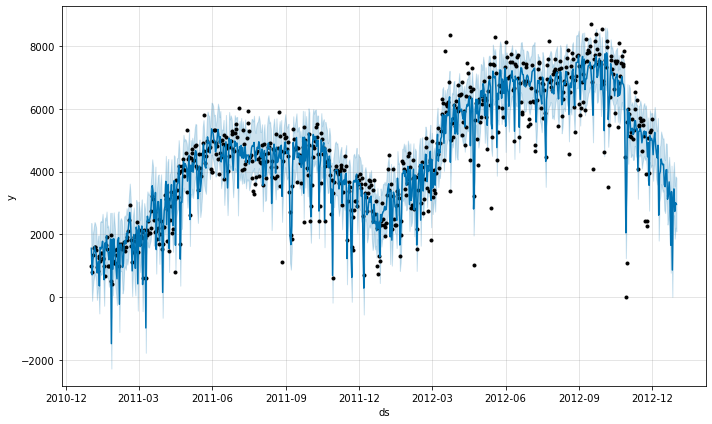

In [33]:
forecast = m2.predict(X_test)
fig = m2.plot(forecast);

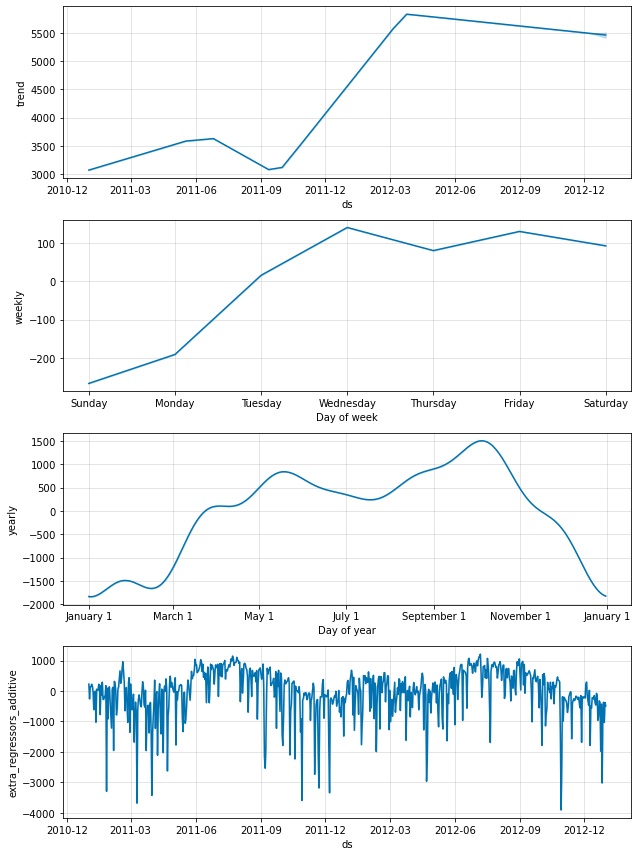

In [34]:
fig = m2.plot_components(forecast);

In [35]:
predicted = forecast[forecast.ds >= train_cut].yhat
real = y_test[-len(predicted):]

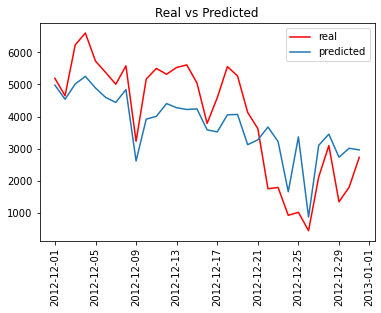

In [36]:
x = X_test.ds[-len(predicted):]
plt.plot(x, real, c='red', label='real')
plt.plot(x, predicted, label='predicted')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Real vs Predicted');

In [37]:
# imprimios evaluación
evaluate(real, predicted)

Mean squared error: 1203591.08
Coefficient of determination: 0.62
MAPE: 0.39


/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


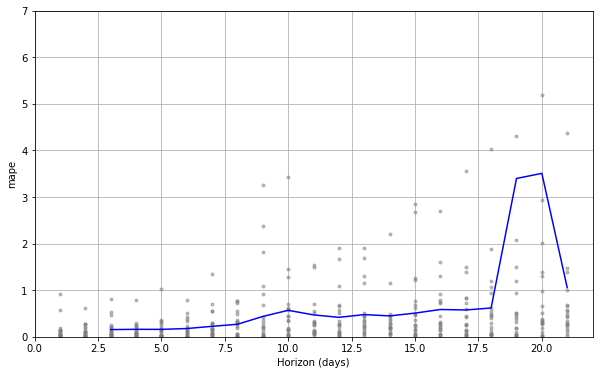

In [38]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.ylim(0,7);

# ANEXO -> Holidays de FbProphet

In [39]:
import holidays

In [40]:
for date, name in sorted(holidays.US(state='CO', years=2012).items()):
  print(date, name)

2012-01-01 New Year's Day
2012-01-02 New Year's Day (Observed)
2012-01-16 Martin Luther King Jr. Day
2012-02-20 Washington's Birthday
2012-05-28 Memorial Day
2012-07-04 Independence Day
2012-09-03 Labor Day
2012-10-08 Columbus Day
2012-11-11 Veterans Day
2012-11-12 Veterans Day (Observed)
2012-11-22 Thanksgiving
2012-12-25 Christmas Day
